In [2]:
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
DATA_DIR = 'C:/Users/Refat/CVPR/Face Mask Dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [4]:
IMG_SIZE = 227
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)



['without_mask', 'with_mask']


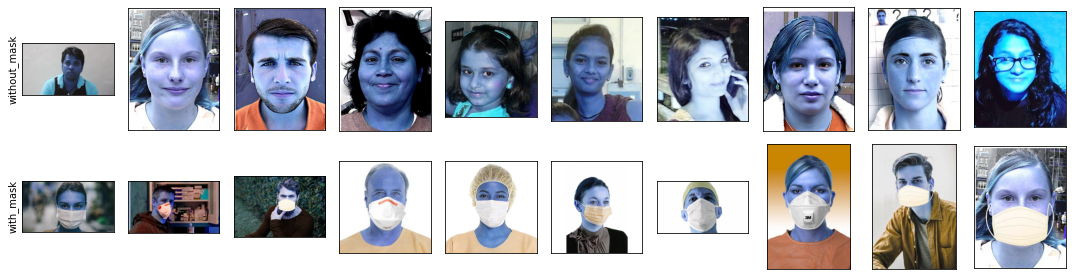

In [7]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)                                                                                                                     
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) # 'E:/DATASETS/classification/Face Mask Dataset/train/WithMask'
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|████████████████████████████████████████████████████████████████████████████████| 658/658 [00:08<00:00, 74.71it/s]

1315


In [6]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 149.85it/s]

142


In [7]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|█████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 139.79it/s]

194


In [8]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [24]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (1315, 227, 227, 3) Y_train= (1315,)


In [10]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).astype('float32').reshape(-1,227,227,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (142, 227, 227, 3) Y_valid= (142,)


In [11]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (194, 227, 227, 3) Y_test= (194,)


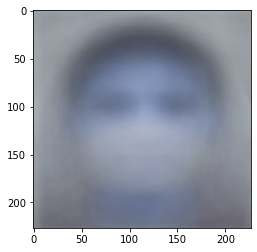

In [12]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [13]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

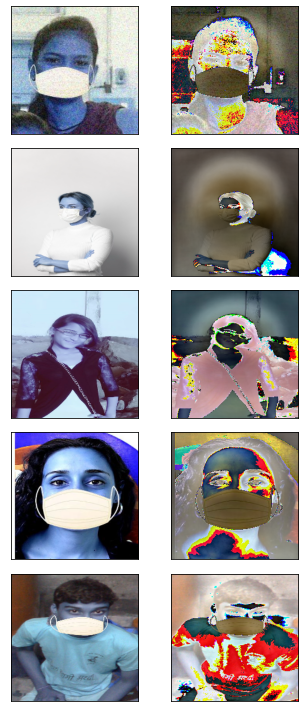

In [14]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [15]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(2),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

In [17]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [18]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=50, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/50
42/42 [==============================] - 87s 2s/step - loss: 1.0211 - accuracy: 0.8422 - val_loss: 43.8041 - val_accuracy: 0.8028
Epoch 2/50
42/42 [==============================] - 81s 2s/step - loss: 0.2231 - accuracy: 0.9449 - val_loss: 1.7849 - val_accuracy: 0.9085
Epoch 3/50
42/42 [==============================] - 86s 2s/step - loss: 0.1819 - accuracy: 0.9558 - val_loss: 0.2046 - val_accuracy: 0.9577
Epoch 4/50
42/42 [==============================] - 75s 2s/step - loss: 0.2158 - accuracy: 0.9420 - val_loss: 0.0805 - val_accuracy: 0.9930
Epoch 5/50
42/42 [==============================] - 68s 2s/step - loss: 0.1567 - accuracy: 0.9546 - val_loss: 0.0395 - val_accuracy: 0.9859
Epoch 6/50
42/42 [==============================] - 67s 2s/step - loss: 0.0991 - accuracy: 0.9651 - val_loss: 0.0139 - val_accuracy: 0.9930
Epoch 7/50
42/42 [==============================] - 67s 2s/step - loss: 0.1170 - accuracy: 0.9625 - val_loss: 0.1116 - val_accuracy: 0.9859
Epoch 8/50
42/42 [=

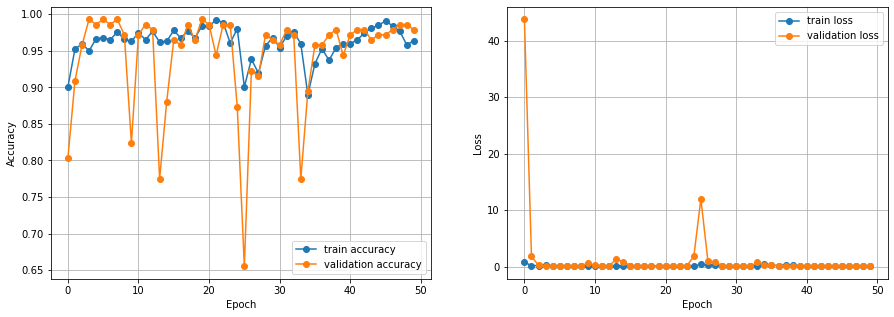

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [20]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

7/7 [==============================] - 3s 408ms/step - loss: 0.0799 - accuracy: 0.9794

Test Accuracy: 0.9793814420700073

Test Loss: 0.07989028841257095
